In [1]:
# import everything from base.py and analysis.py
from analysis import * 

Success!
Success!


In [4]:
import pandas as pd
path = '../../Data/tracked_particles.hdf5'
with pd.HDFStore(path) as hdf:
    keys = [k[1:] for k in hdf.keys()]
    print('Available keys:', *keys)

Available keys: h329_7


In [5]:
key = 'h329_7'
data = pd.read_hdf(path, key=key)
len(np.unique(data.pid))

18101

In [6]:
#check if I can load the data in pandas
sim, haloid = str(key[:4]), int(key[5:])
data = read_tracked_particles(sim, haloid)
data.head()

,time,pid,rho,temp,mass,coolontime,r,r_per_Rvir,x,y,...,in_IGM,dt,r_gal,host_r_gal,sat_disk,sat_halo,host_disk,host_halo,other_sat,IGM
0,11.32266,161935,0.000039,31022.804688,26510.536704,0.0,30.374641,0.805864,-21.127448,21.263372,...,False,0.323235,2.038042,4.673006,False,True,False,False,False,False
1,11.32266,163530,0.000034,38419.250000,26510.536704,0.0,31.340455,0.831488,16.445177,17.828924,...,True,0.323235,2.038042,4.673006,False,False,False,False,False,True
2,11.32266,163562,0.000031,31096.404297,26510.536704,0.0,35.557924,0.943380,-5.543136,11.591402,...,False,0.323235,2.038042,4.673006,False,True,False,False,False,False
3,11.32266,163850,0.000048,35371.398438,26510.536704,0.0,26.396696,0.700326,-13.222491,22.819563,...,False,0.323235,2.038042,4.673006,False,True,False,False,False,False
4,11.32266,163870,0.000044,27943.220703,26510.536704,0.0,30.116448,0.799014,-0.617843,10.539317,...,False,0.323235,2.038042,4.673006,False,True,False,False,False,False


/tmp/ipykernel_513485/309953887.py:60: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Reds', 12)


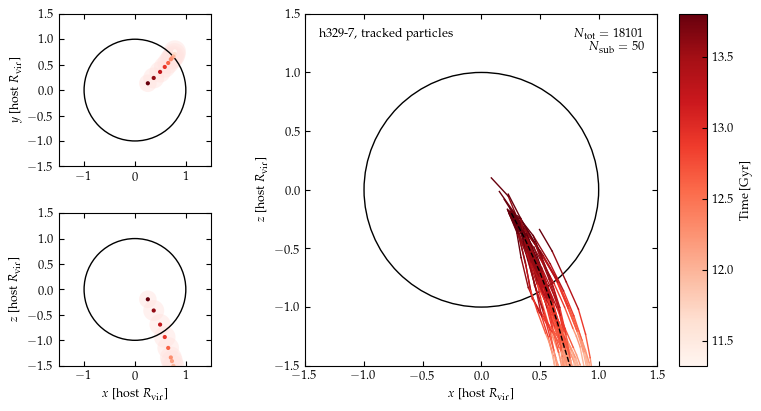

In [7]:
#replicate particle tracking plots

R = 1.5 # in Rvir, the maximum radius to plot 
N = 50 # number of particles to select in subsample (default: 50)

fig = plt.figure(dpi=100, figsize=(7.5,4))
gs = mpl.gridspec.GridSpec(2,5, width_ratios = [1,0.1,1,1,0.15], figure=fig)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[1,0])
ax2 = plt.subplot(gs[0:,2:-1])
cbax = plt.subplot(gs[:,-1])

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax0.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax1.add_artist(host_radius)

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax2.add_artist(host_radius)

x_rel, y_rel, z_rel, Rvirs, ts = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
for t in np.unique(data.time):
    d = data[data.time==t]
    sat_x, sat_y, sat_z = np.mean(d.sat_Xc), np.mean(d.sat_Yc), np.mean(d.sat_Zc)
    host_x, host_y, host_z = np.mean(d.host_Xc), np.mean(d.host_Yc), np.mean(d.host_Zc)
    
    h1Rvir = np.mean(d.hostRvir)
    satRvir = np.mean(d.satRvir)
    
    x_rel = np.append(x_rel, (sat_x-host_x)/h1Rvir)
    y_rel = np.append(y_rel, (sat_y-host_y)/h1Rvir)
    z_rel = np.append(z_rel, (sat_z-host_z)/h1Rvir)
    
    Rvirs = np.append(Rvirs, satRvir/h1Rvir*1100)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_y-host_y)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax0.add_artist(radii)
    
    radii = plt.Circle(((sat_x-host_x)/h1Rvir,(sat_z-host_z)/h1Rvir),
                     satRvir/h1Rvir, ec='none',fc='mistyrose', alpha=0.5, fill=True, zorder=0.5)
    ax1.add_artist(radii)
    
    ts = np.append(ts,t)
    
ax0.scatter(x_rel, y_rel, c=ts, cmap='Reds', s=4, zorder=2)
ax1.scatter(x_rel, z_rel, c=ts, cmap='Reds', s=4, zorder=2)
# ax2.plot(x_rel, z_rel, 'k--', linewidth=1, zorder=1)
# ax2.plot(x_rel, z_rel, 'k--', linewidth=1, zorder=1)
ax2.plot(x_rel, z_rel, 'k--', linewidth=1, zorder=1000)

pids = np.unique(data.pid)
np.random.seed(100)
pids_sub = np.random.choice(pids, size=N)

for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]
    
    cmap = mpl.cm.get_cmap('Reds', 12)
    tmin, tmax = np.min(d.time), np.max(d.time)
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        h1Rvir = list(d.hostRvir)[i_prev]
        x1 = list(d.x_rel_host)[i_prev] / h1Rvir
        y1 = list(d.y_rel_host)[i_prev] / h1Rvir
        z1 = list(d.z_rel_host)[i_prev] / h1Rvir
        
        h1Rvir = list(d.hostRvir)[i]
        x2 = list(d.x_rel_host)[i] / h1Rvir
        y2 = list(d.y_rel_host)[i] / h1Rvir
        z2 = list(d.z_rel_host)[i] / h1Rvir
        t = list(d.time)[i]
        
        c = cmap((t-tmin)/(tmax-tmin))
        ax2.plot([x1,x2],[z1,z2],color=c, linewidth=1, zorder=j)

        i_prev = i
    
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=mpl.cm.Reds, orientation='vertical', 
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax),
                                label='Time [Gyr]')

ax1.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax1.set_ylabel(r'$z$ [host $R_{\rm vir}$]')
ax0.set_ylabel(r'$y$ [host $R_{\rm vir}$]')
ax2.annotate(f"{key.replace('_','-')}, tracked particles", (0.04, 0.96), xycoords='axes fraction', va='top')
ax2.annotate(r'$N_{\rm tot} =$' + fr' ${len(pids)}$'+'\n'+r'$N_{\rm sub} =$' + fr' ${N}$', 
            (0.96, 0.96), xycoords='axes fraction', va='top', ha='right')

ax0.set_xlim(-R,R)
ax0.set_ylim(-R,R)
ax1.set_xlim(-R,R)
ax1.set_ylim(-R,R)
ax2.set_xlim(-R,R)
ax2.set_ylim(-R,R)

ax0.set_aspect('equal')
ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax2.set_xlabel(r'$x$ [host $R_{\rm vir}$]')
ax2.set_ylabel(r'$z$ [host $R_{\rm vir}$]')


ax0.tick_params(top=True,right=True,direction='in', which='both')
ax1.tick_params(top=True,right=True,direction='in', which='both')
ax2.tick_params(top=True,right=True,direction='in', which='both')

plt.savefig(f'plots/orbits/{key}_orbit.pdf')

plt.show()

/tmp/ipykernel_513485/2972722413.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_base = mpl.cm.get_cmap('Greys')


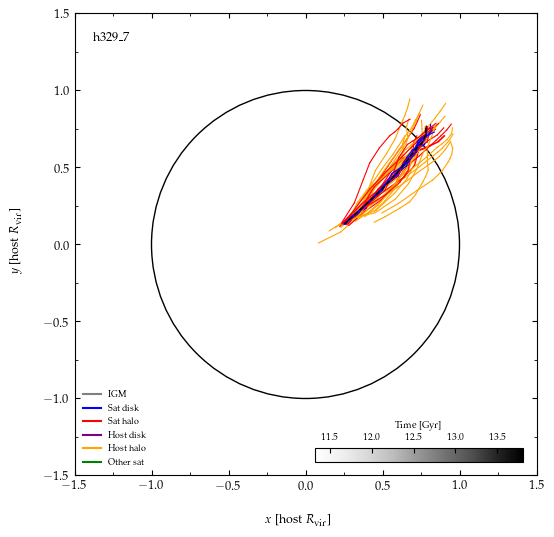

In [26]:
#mode advanced plotting
R = 1.5 # in Rvir, the maximum radius to plot 
N = 50 # number of particles to select in subsample

fig = plt.figure(dpi=100, figsize=(6,6), constrained_layout=False)
ax = plt.subplot()

host_radius = plt.Circle((0, 0), 1, color='k', fill=False)
ax.add_artist(host_radius)

#plotting
sim = key[:4]
haloid = key[-1:]
data = read_tracked_particles(sim,haloid) #this might be redefining

#colors based on different eventual state of gas particles
cmap_base = mpl.cm.get_cmap('Greys')
# cmaps = np.array([
#         mpl.colormaps['Blues'],
#         mpl.colormaps['Reds'],
#         mpl.cm.get_cmap('Purples'),
#         mpl.cm.get_cmap('Oranges'),
#         cmap_base,
#         mpl.cm.get_cmap('Greens')
#     ])
colors = np.array(['blue', 'red', 'purple', 'orange', 'grey', 'green'])

pids = np.unique(data.pid)
np.random.seed(100)
pids_sub = np.random.choice(pids, size=N)

for j,pid in enumerate(pids_sub):
    d = data[data.pid==pid]


    tmin, tmax = np.min(data.time), np.max(data.time)

    sat_disk = d.sat_disk.iloc[-1]
    sat_halo = d.sat_halo.iloc[-1]
    host_disk = d.host_disk.iloc[-1]
    host_halo = d.host_halo.iloc[-1]
    IGM = d.IGM.iloc[-1]
    other_sat = d.other_sat.iloc[-1]
    options = np.array(['sat_disk','sat_halo','host_disk','host_halo','IGM','other_sat'])
    bools = np.array([sat_disk, sat_halo, host_disk, host_halo, IGM,other_sat])
    classification = options[bools][0]
    
    i_prev = 0
    for i in range(len(d)-1):
        i += 1
        h1Rvir = list(d.hostRvir)[i_prev]
        x1 = list(d.x_rel_host)[i_prev] / h1Rvir
        y1 = list(d.y_rel_host)[i_prev] / h1Rvir
        z1 = list(d.z_rel_host)[i_prev] / h1Rvir

        h1Rvir = list(d.hostRvir)[i]
        x2 = list(d.x_rel_host)[i] / h1Rvir
        y2 = list(d.y_rel_host)[i] / h1Rvir
        z2 = list(d.z_rel_host)[i] / h1Rvir
        t = list(d.time)[i]

        #cmap = cmaps[options == classification][0]
        color = colors[options == classification][0]
        
        #c = cmap((t-tmin)/(tmax-tmin))
        ax.plot([x1,x2],[y1,y2],color=color, linewidth=0.8, zorder=j)

        i_prev = i

out = data.groupby(['time'])[['sat_Xc','sat_Yc','host_Xc','host_Yc','hostRvir']].apply(lambda x : x.mean()).reset_index()
out['X'] = (out.sat_Xc-out.host_Xc)/out.hostRvir
out['Y'] = (out.sat_Yc-out.host_Yc)/out.hostRvir

ax.plot(out.X, out.Y, linewidth=1, linestyle='--', color='k', zorder=1001)

cbax = ax.inset_axes([0.52,0.03,0.45, 0.03], zorder=1000)
cb1 = mpl.colorbar.ColorbarBase(cbax, cmap=cmap_base, orientation='horizontal', ticklocation='top',
                                norm = mpl.colors.Normalize(vmin=tmin, vmax=tmax))
cb1.set_label('Time [Gyr]', fontsize=7)
cb1.ax.tick_params(labelsize=7)
cb1.ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.annotate(key, (0.04, 0.96), xycoords='axes fraction', va='top', zorder=1000)
#ax.annotate(r'$N_{\rm tot} =$' + fr' ${len(pids)}$'+'\n'+r'$N_{\rm sub} =$' + fr' ${N}$', (0.96, 0.96), xycoords='axes fraction', va='top', ha='right')
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')
ax.tick_params(top=True,right=True,direction='in',which='both')
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

fig.text(0.5, 0.03, r'$x$ [host $R_{\rm vir}$]', ha='center')
fig.text(0.02, 0.5, r'$y$ [host $R_{\rm vir}$]', va='center', rotation='vertical')

ax.plot([-5,-5],[-5,-4],color=colors[4], label='IGM')
ax.plot([-5,-5],[-5,-4],color=colors[0], label='Sat disk')
ax.plot([-5,-5],[-5,-4],color=colors[1], label='Sat halo')
ax.plot([-5,-5],[-5,-4],color=colors[2], label='Host disk')
ax.plot([-5,-5],[-5,-4],color=colors[3], label='Host halo')
ax.plot([-5,-5],[-5,-4],color=colors[5], label='Other sat')

ax.legend(loc='lower left', fontsize=6.5, frameon=False).set_zorder(2000)

plt.show()

In [34]:
#understand the gas fraction
data.groupby(['time'])[['mass','sat_disk','sat_halo','host_disk','host_halo','other_sat','IGM']]
# convenience function that plots a single panel of the fractions plots, so we can scale up to multiple panels easily
def fill_fractions_ax(key, ax, label=False, show_y_ticks=False):
    sim = str(key[:4])
    haloid = int(key[5:])
    print(sim,haloid)
    
    # read in tracked particles
    data = read_tracked_particles(sim,haloid,verbose=False)

    times = np.unique(data.time)
    frac_satdisk,frac_sathalo,frac_hostdisk,frac_hosthalo,frac_othersat,frac_IGM = np.array([]),np.array([]),np.array([]),np.array([]),np.array([]),np.array([])

    for t in times:
        d = data[np.abs(data.time-t) < 0.01]
        
        mass_div = np.sum(d.mass)
        
        frac_satdisk = np.append(frac_satdisk,np.sum(d.mass[d.sat_disk])/mass_div)
        frac_sathalo = np.append(frac_sathalo,np.sum(d.mass[d.sat_halo])/mass_div)
        frac_hostdisk = np.append(frac_hostdisk,np.sum(d.mass[d.host_disk])/mass_div)
        frac_hosthalo = np.append(frac_hosthalo,np.sum(d.mass[d.host_halo])/mass_div)
        frac_othersat = np.append(frac_othersat,np.sum(d.mass[d.other_sat])/mass_div)
        frac_IGM = np.append(frac_IGM,np.sum(d.mass[d.IGM])/mass_div)

    timescales = read_timescales()
    timescales = timescales[(timescales.sim==key[:4])&(timescales.haloid==int(key[5:]))]
    tinfall = age - timescales.tinfall.tolist()[0]
    tquench = age - timescales.tquench.tolist()[0]

    lw = 0.6
    alpha = 0.3
    fontsize = 8
    colors = ['mediumblue', 'tab:red', 'darkorchid', 'darkorange', 'g', 'k', 'lightblue']
    
    ax.fill_between(times, 0, frac_satdisk,fc=colors[0], alpha=alpha, label='Sat Disk')
    ax.plot(times, frac_satdisk, color=colors[0], linewidth=lw, zorder=6)

    ax.fill_between(times, frac_satdisk, 
                    frac_satdisk+frac_sathalo, fc=colors[1], alpha=alpha, label='Sat Halo')
    ax.plot(times, frac_satdisk+frac_sathalo, color=colors[1], linewidth=lw, zorder=5)

    ax.fill_between(times, frac_satdisk+frac_sathalo, 
                    frac_satdisk+frac_sathalo+frac_hostdisk, fc=colors[2], alpha=alpha, label='Host Disk')
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk, color=colors[2], linewidth=lw, zorder=4)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk, 
                    frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, fc=colors[3], alpha=alpha, label='Host Halo')
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo, color=colors[3], linewidth=lw, zorder=3)

    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo,
                    frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat, fc=colors[4], alpha=alpha, label='Other Sat')
    ax.plot(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat, color=colors[4], linewidth=lw, zorder=2)
    
    ax.fill_between(times, frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat,
                    frac_satdisk+frac_sathalo+frac_hostdisk+frac_hosthalo+frac_othersat+frac_IGM, fc=colors[5], alpha=alpha, label='IGM')

    ax.axline((tinfall,0),(tinfall,1),linestyle='--', linewidth=0.5, color='k')
    ax.axline((tquench,0),(tquench,1),linestyle=':', linewidth=0.5, color='k')

    ax.set_xlim(min(times),max(times))
    ax.set_ylim(0,1)

    if label:
        if key=='h242_24':
            ax.annotate('Sat \n Disk',(7.3,0.28),ha='center', va='center', color=colors[0], size=fontsize)
            ax.annotate('Sat \n Halo',(6.7,0.45),ha='center', va='center', color=colors[1], size=fontsize)
            ax.annotate('Host \n Disk',(12.5,0.15),ha='center', va='center', color=colors[2], size=fontsize)
            ax.annotate('Host \n Halo',(9.5,0.55),ha='center', va='center', color=colors[3], size=fontsize)
            ax.annotate('IGM',(6.7,0.87),ha='center', va='center', color=colors[5], size=fontsize)
    if not show_y_ticks:
        ax.tick_params(labelleft=False)

    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
    ax.tick_params(direction='in', which='both', top=True,right=True)

    ax.annotate(key.replace('_','-'), (0.94, 0.92), xycoords='axes fraction', ha='right', va='top',
                bbox=dict(boxstyle='round,pad=0.4', fc='w', ec='0.5', alpha=0.9), zorder=100)

    ax.legend(loc='lower left', fontsize=6.5, frameon=False).set_zorder(2000)

h329 7


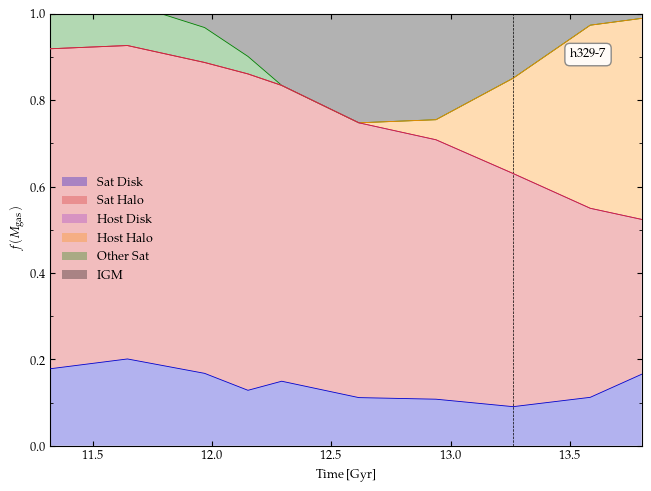

In [35]:
#plotting
fig, ax = plt.subplots(1,1,dpi=100)
fill_fractions_ax('h329_7',ax,show_y_ticks=True)
ax.set_xlabel('Time [Gyr]')
ax.set_ylabel(r'$f(M_{\rm gas})$')
plt.legend()
plt.show()

In [36]:
stars = pd.read_hdf('../../Data/tracked_stars.hdf5', key='h329_7')
particles = read_tracked_particles('h329',7)
stars = stars[stars.tform > np.min(particles.time)]

FileNotFoundError: File ../../Data/tracked_stars.hdf5 does not exist